In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

from scipy import stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from causalgraphicalmodels import CausalGraphicalModel
import daft

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is based on the [homework of week 8](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week08.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/blob/Experimental/data/)
<br>

In [9]:
df = pd.read_csv('../data/bangladesh.csv', sep=';')

# remove dots from columns names to become easier to address them
df.rename(columns= {'use.contraception': 'use_contraception', 
                    'living.children': 'living_children',
                    'age.centered': 'age_centered'}, inplace=True)
df

,woman,district,use_contraception,living_children,age_centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1
...,...,...,...,...,...,...
1929,1930,61,0,4,14.4400,0
1930,1931,61,0,3,-4.5599,0
1931,1932,61,0,4,14.4400,0
1932,1933,61,0,1,-13.5600,0


In [10]:
df.district.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59, 60, 61])

By checking the values from district we perceive number `54` is missing. Below, a contiguous integer set is created.

In [19]:
df['dist_id'] = df.district.factorize()[0]
df.head()

,woman,district,use_contraception,living_children,age_centered,urban,dist_id
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


## Fixed-effects model

In [34]:
with pm.Model() as m1:
    a_dist = pm.Normal('a_dist', 0, 1.5, shape=len(df.dist_id.unique()))
    p = pm.math.invlogit(a_dist[df.dist_id.values])
    
    contraception = pm.Binomial('contraception', n=1, p=p, observed=df.use_contraception.values)
    
    m1_trace = pm.sample()
    m1_post_pred = pm.sample_posterior_predictive(m1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dist]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (60), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_dist\n0'}>,
        <AxesSubplot:title={'center':'a_dist\n0'}>],
       [<AxesSubplot:title={'center':'a_dist\n1'}>,
        <AxesSubplot:title={'center':'a_dist\n1'}>],
       [<AxesSubplot:title={'center':'a_dist\n2'}>,
        <AxesSubplot:title={'center':'a_dist\n2'}>],
       [<AxesSubplot:title={'center':'a_dist\n3'}>,
        <AxesSubplot:title={'center':'a_dist\n3'}>],
       [<AxesSubplot:title={'center':'a_dist\n4'}>,
        <AxesSubplot:title={'center':'a_dist\n4'}>],
       [<AxesSubplot:title={'center':'a_dist\n5'}>,
        <AxesSubplot:title={'center':'a_dist\n5'}>],
       [<AxesSubplot:title={'center':'a_dist\n6'}>,
        <AxesSubplot:title={'center':'a_dist\n6'}>],
       [<AxesSubplot:title={'center':'a_dist\n7'}>,
        <AxesSubplot:title={'center':'a_dist\n7'}>],
       [<AxesSubplot:title={'center':'a_dist\n8'}>,
        <AxesSubplot:title={'center':'a_dist\n8'}>],
       [<AxesSubplot:title={'center':'a_dist\n9'}>,
   

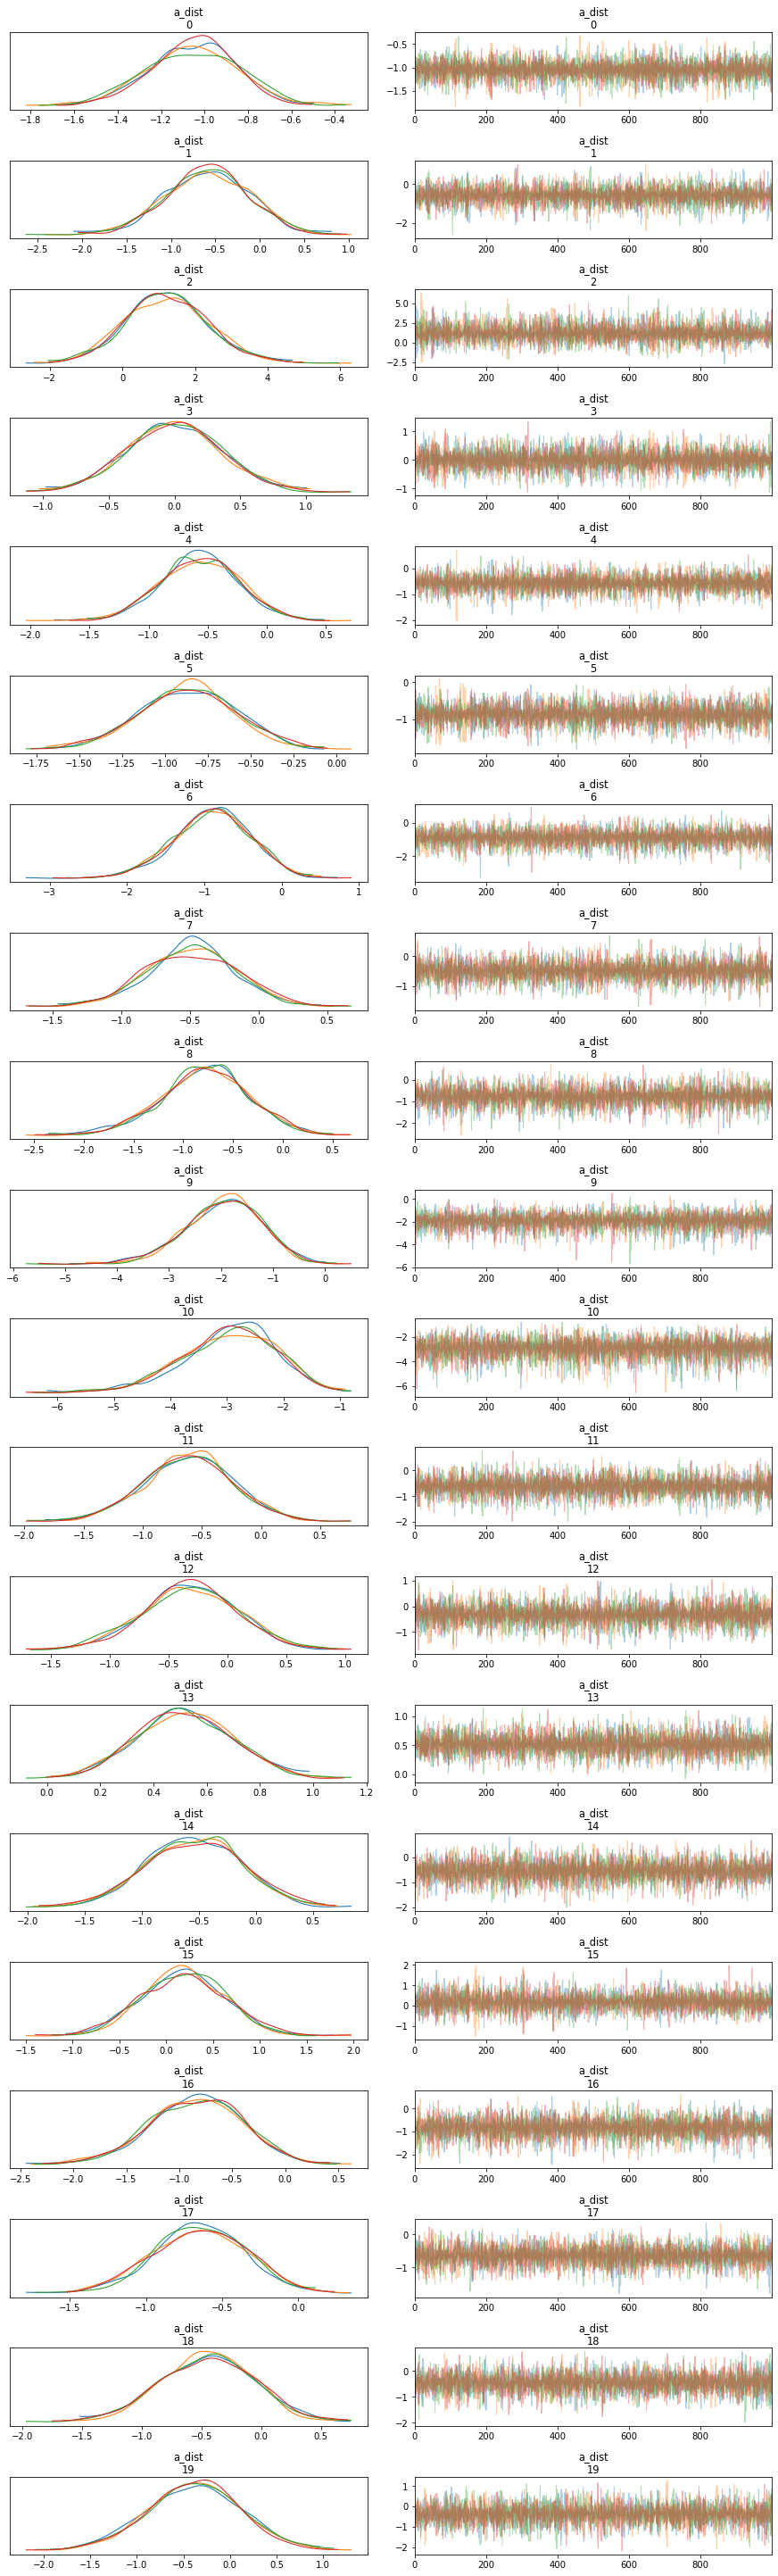

In [35]:
az.plot_trace(m1_trace)

## Multilevel model with varying intercepts

In [36]:
with pm.Model() as m2:
    a_bar = pm.Normal('a_bar', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    
    a_dist = pm.Normal('a_dist', a_bar, sigma, shape=len(df.dist_id.unique()))
    #a_dist = pm.Normal('a_dist', 0, 1.5, shape=len(df.dist_id.unique()))
    p = pm.math.invlogit(a_dist[df.dist_id.values])
    
    contraception = pm.Binomial('contraception', n=1, p=p, observed=df.use_contraception.values)
    
    m2_trace = pm.sample()
    m2_post_pred = pm.sample_posterior_predictive(m2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dist, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (62), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_dist\n0'}>,
        <AxesSubplot:title={'center':'a_dist\n0'}>],
       [<AxesSubplot:title={'center':'a_dist\n1'}>,
        <AxesSubplot:title={'center':'a_dist\n1'}>],
       [<AxesSubplot:title={'center':'a_dist\n2'}>,
        <AxesSubplot:title={'center':'a_dist\n2'}>],
       [<AxesSubplot:title={'center':'a_dist\n3'}>,
        <AxesSubplot:title={'center':'a_dist\n3'}>],
       [<AxesSubplot:title={'center':'a_dist\n4'}>,
        <AxesSubplot:title={'center':'a_dist\n4'}>],
       [<AxesSubplot:title={'center':'a_dist\n5'}>,
        <AxesSubplot:title={'center':'a_dist\n5'}>],
       [<AxesSubplot:title={'center':'a_dist\n6'}>,
        <AxesSubplot:title={'center':'a_dist\n6'}>],
       [<AxesSubplot:title={'center':'a_dist\n7'}>,
        <AxesSubplot:title={'center':'a_dist\n7'}>],
       [<AxesSubplot:title={'center':'a_dist\n8'}>,
        <Ax

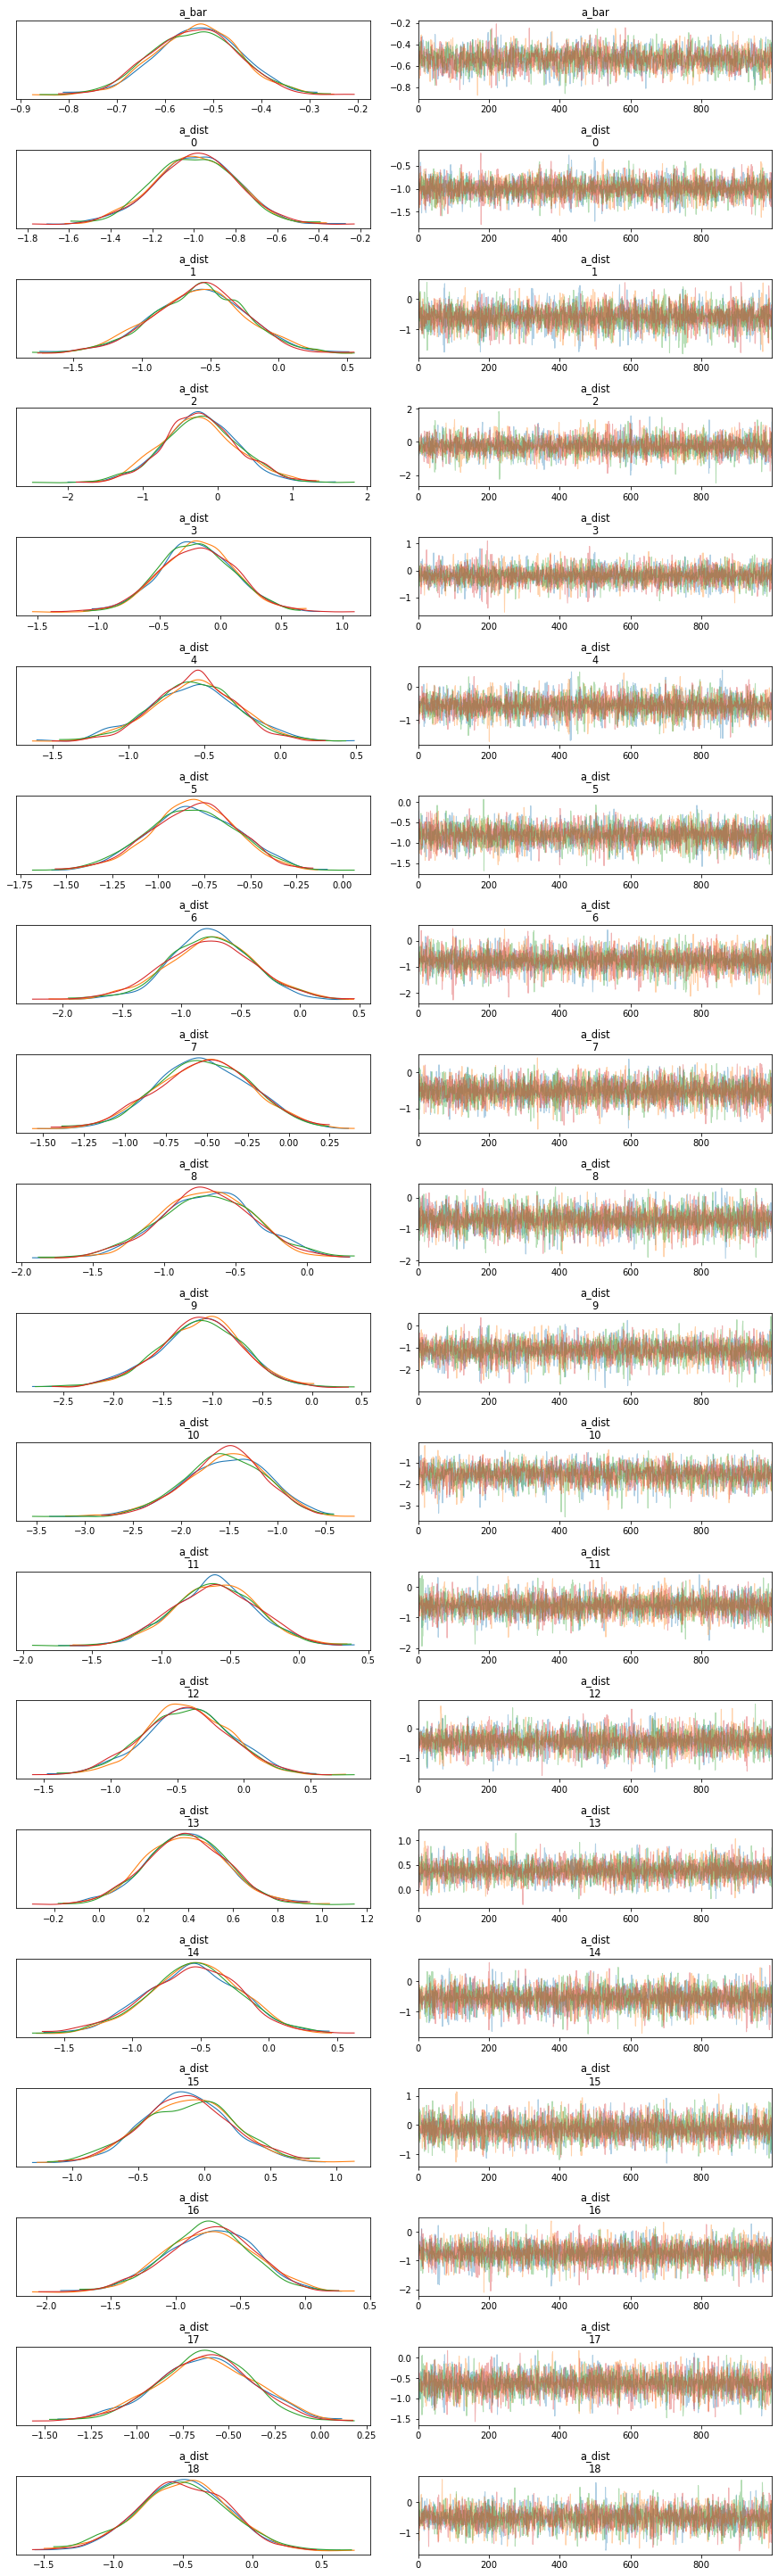

In [37]:
az.plot_trace(m2_trace)

In [118]:
m2_trace['a_dist'].shape

(4000, 60)

In [120]:
#df['m1_contraception'] = logistic(m1_post_pred['contraception'].mean(0))
#df['m2_contraception'] = logistic(m2_post_pred['contraception'].mean(0))


In [123]:
#df_sum = pd.pivot_table(df.copy(), values=['use_contraception','m1_contraception', 'm2_contraception'],
#                        index=['dist_id'], 
#                        aggfunc={'dist_id':np.size, 'use_contraception':np.sum, 
#                                 'm1_contraception': np.sum, 'm2_contraception': np.sum})
df_sum = pd.pivot_table(df, values=['use_contraception'], index=['dist_id'], 
                        aggfunc={'dist_id':np.size, 'use_contraception':np.sum})

df_sum['m1_a'] = m1_trace['a_dist'].mean(0)
df_sum['m2_a'] = m2_trace['a_dist'].mean(0)

df_sum.rename(columns={'dist_id': 'total_women'})

,total_women,use_contraception,m1_a,m2_a
dist_id,,,,
0,117,30,-1.054291,-0.994411
1,20,7,-0.590516,-0.585190
2,2,2,1.241780,-0.232337
3,30,15,-0.001210,-0.193330
4,39,14,-0.569674,-0.568655
5,65,19,-0.868793,-0.812584
6,18,5,-0.899980,-0.758041
7,37,14,-0.487697,-0.518284
8,23,7,-0.784578,-0.703620


In [108]:
df_sum.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59],
           dtype='int64', name='dist_id')

[]

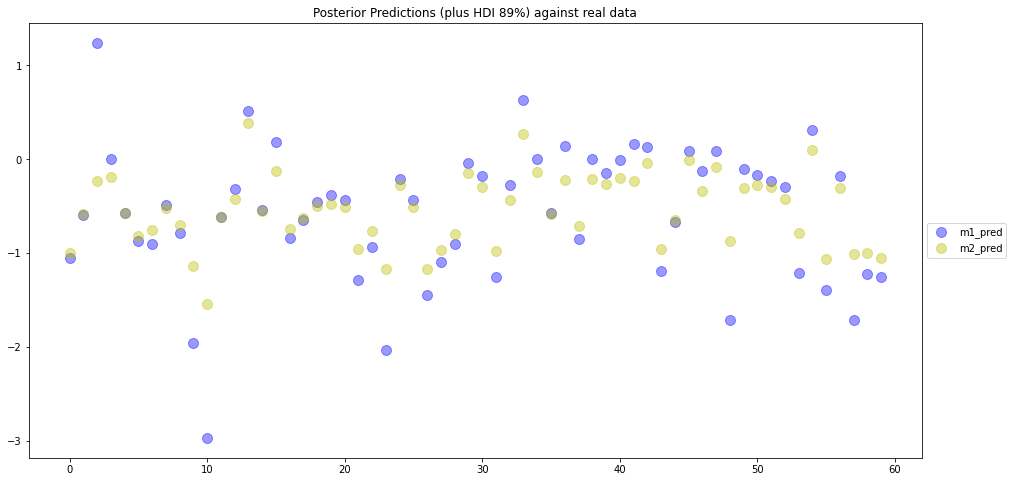

In [126]:
_, ax = plt.subplots(figsize=(16,8))
ax.scatter(df_sum.index, df_sum.m1_a, c='b', s=100, alpha=0.4, label='m1_pred')
ax.scatter(df_sum.index, df_sum.m2_a, c='y', s=100, alpha=0.4, label='m2_pred')


plt.title('Posterior Predictions (plus HDI 89%) against real data')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()

In [67]:
df.loc[df['dist_id']==4].agg(['sum', 'size'])

,woman,district,use_contraception,living_children,age_centered,urban,dist_id
sum,7371,195,14,110,-34.8317,2,156
size,39,39,39,39,39.0000,39,39


In [63]:
np.size(df.loc[df['dist_id']==1])

140

---
---

In [29]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Tue Apr 06 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

matplotlib: 3.3.2
numpy     : 1.19.1
seaborn   : 0.11.0
arviz     : 0.10.0
daft      : 0.1.0
pandas    : 1.0.5
pymc3     : 3.9.3
scipy     : 1.5.4

Watermark: 2.1.0

